In [1]:
import scipy
print(scipy.__version__)
%matplotlib inline

1.1.0


In [5]:
%load_ext memory_profiler

In [2]:
import cellgrid 
import numpy as np
from MDAnalysis.lib.distances import distance_array
from initialization import init_uniform
from MDAnalysis.lib.pkdtree import PeriodicKDTree
import itertools

In [110]:
def bf_select(box, points, maxdist):
    bonds = []
    distance = []
    for i,coordinate in enumerate(points):
        dist = distance_array(points[i][None, :], points[i + 1:],box=box)[0]
        idx = np.where((dist <= maxdist))[0]
        for a in idx:
            j = i + 1 + a
            atom_j = points[j]
            bonds.append((i, j))
            distance.append((dist[a]))
    return (np.asarray(bonds), np.asarray(distance))
    
def cg_select(box, points, maxdist):
    indx,dist = cellgrid.capped_self_distance_array(points,maxdist,box=box[:3])
    mask = np.where(dist<maxdist)
    return indx[mask],dist[mask]

def kdtree_select(box,points,maxdist):
    epsilon = 1e-5 #to avoid the same point
    kdtree = PeriodicKDTree(box,bucket_size=10)
    kdtree.set_coords(points)
    pair,distances = [],[]
    for idx,centers in enumerate(points):
        kdtree.search(centers,maxdist)
        indices = kdtree.get_indices()
        indices = [i for i in indices if i > idx]
        dist = distance_array(centers.reshape((1,3)), points[indices],box=box)[0]
        mask = np.where((dist > epsilon) & (dist <= maxdist))[0]
        for j in mask:
            pair.append((idx,indices[j]))
            distances.append(dist[j])
    return np.asarray(pair), np.asarray(distances)

In [118]:
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

In [111]:
box = np.array([100,100,100,90,90,90],dtype=np.float32)
points = init_uniform(box,Npoints=1000)
maxdist = 10.0

In [112]:
#Brute Force
bf = bf_select(box,points,maxdist)
#CellGrid Selection
cg = cg_select(box,points,maxdist)
#KDTree selections
kd = kdtree_select(box,points,maxdist)

In [113]:
bf[1].shape

(2137,)

In [114]:
cg[1].shape

(2137,)

In [115]:
kd[1].shape

(2137,)

In [116]:
#Testing
#Number of contacts
np.testing.assert_equal(kd[1].shape,cg[1].shape) #Comparing total number of pairs with distance array
np.testing.assert_equal(bf[1].shape,cg[1].shape)

#Array Values 
np.testing.assert_array_almost_equal(np.sort(bf[1].astype(np.float64)),np.sort(cg[1]),decimal=5) #Comparing array values
np.testing.assert_almost_equal(bf[1],kd[1]) 

In [117]:
##Benchmarking - Time ------------> Number of particles
#Setting
box = np.array([100,100,100,90,90,90],dtype=np.float32)
maxdist = 10.0

In [120]:
from tqdm import tqdm_notebook
from collections import defaultdict

result = defaultdict(list)

for N in tqdm_notebook(np.unique(np.logspace(2, 5, num = 10, dtype = np.int32))):
    points = get_coords(box, N)
    
    #KDTree
    res = %timeit -o -q kdtree_select(box,points,maxdist)
    result['pkdt'].append(res.average)
    
    #Brute Force
    res = %timeit -o -q bf_select(box, points, maxdist)
    result['bf'].append(res.average)
    
    #CG
    res = %timeit -o -q cg_select(box, points, maxdist)
    result['cg'].append(res.average)
    
    result['N'].append(N)
# Benchmarks with number of particles for single cutoff


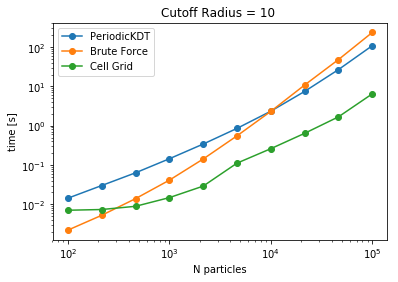

In [124]:
#Plots for visual comparison
import matplotlib
import matplotlib.pyplot as plt

fig, axes = plt.subplots()

axes.plot(result['N'], result['pkdt'], 'o-', label='PeriodicKDT')
axes.plot(result['N'], result['bf'], 'o-', label='Brute Force')
axes.plot(result['N'], result['cg'], 'o-', label='Cell Grid')
axes.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Cutoff Radius = 10 ')
axes.legend()

In [129]:
#####Benchmark for different cutoff radius and number of particles for Cellgrid
#Setting
box = np.array([100,100,100,90,90,90],dtype=np.float32)
Npoints = np.logspace(2, 5, num=5, dtype=np.int32)
Maxdist = np.linspace(2 , 10, num = 8)

In [130]:
from tqdm import tqdm_notebook
from collections import defaultdict

result = defaultdict(list)

for N in tqdm_notebook(np.unique(Npoints)):
    
    points = get_coords(box, N)
    
    for maxdist in tqdm_notebook(np.unique(Maxdist)):
        
    #KDTree
        res = %timeit -o -q kdtree_select(box,points,maxdist)
        result['pkdt'+'.'+str(maxdist)].append(res.average)
    
    #Brute Force
        res = %timeit -o -q bf_select(box, points, maxdist)
        result['bf'+'.'+str(maxdist)].append(res.average)
    
    #CG
        res = %timeit -o -q cg_select(box, points, maxdist)
        result['cg'+'.'+str(maxdist)].append(res.average)
    
    result['N'].append(N)
# Benchmarks with number of particles for single cutoff


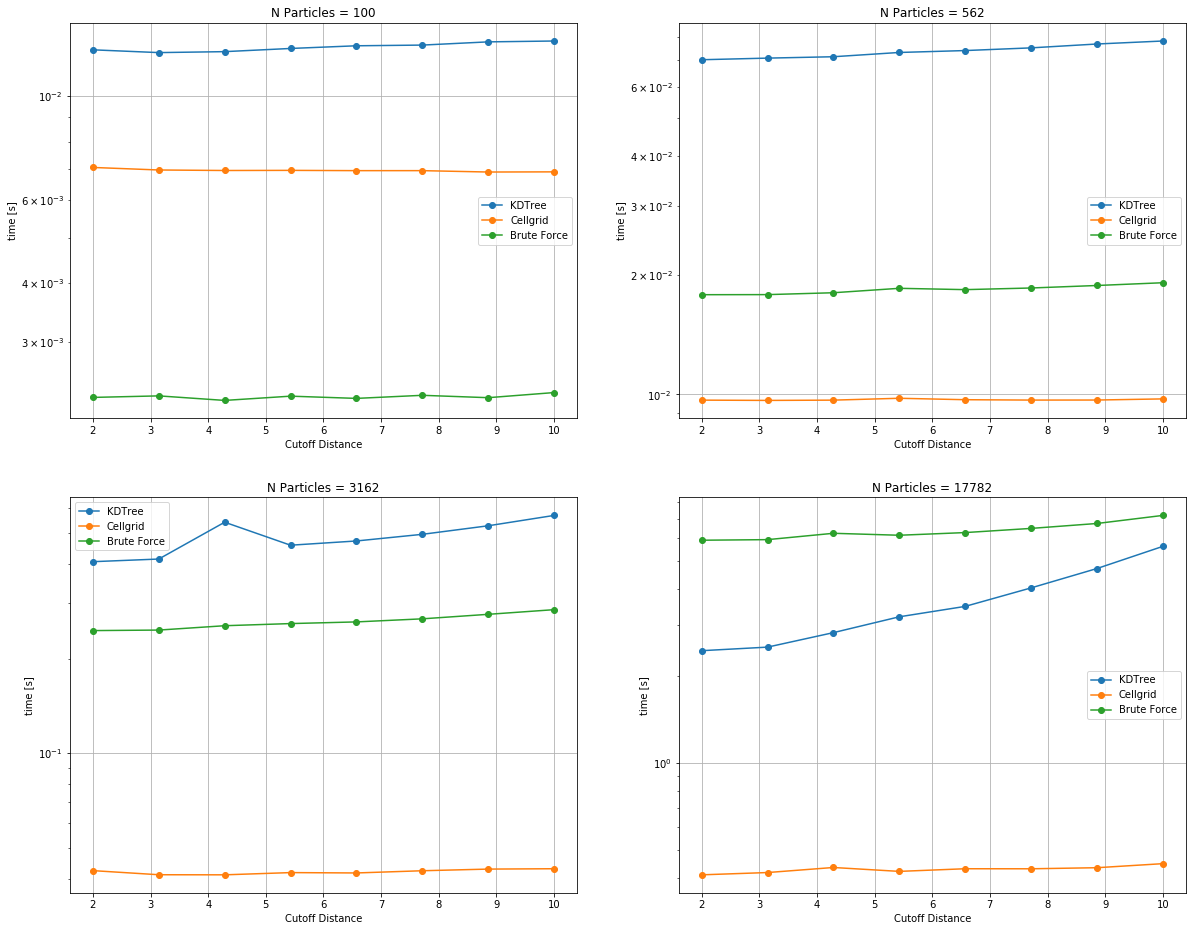

In [154]:
#Plots for visual comparison
import matplotlib
import matplotlib.pyplot as plt

nrows, ncols = 3, 2
fig, axes = plt.subplots(ncols = ncols, nrows = nrows-1, figsize = (20,16))
result_dist = defaultdict(list)

label = {'pkdt':"KDTree", 'cg':"Cellgrid", 'bf':"Brute Force"}

for j in range((nrows-1)):
    for i in range((ncols)):
        result_dist = defaultdict(list)
        num = j*ncols + i
        N = Npoints[num]
        ax = axes[j,i]
        for key in result:
            method = key.split('.')[0]
            result_dist[method].append(result[key][num])
        for key in ['pkdt','cg', 'bf']:
            ax.plot(Maxdist, result_dist[key], '-o', label = label[key])
        ax.set(xlabel='Cutoff Distance', ylabel='time [s]', yscale='log', title='N Particles = {}'.format(Npoints[num]))
        ax.legend()
        ax.grid(True)

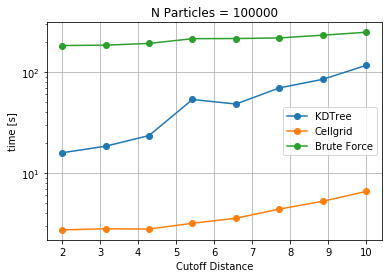

In [160]:
fig, axes = plt.subplots()
result_dist = defaultdict(list)
N = Npoints[-1]
for key in result:
    method = key.split('.')[0]
    result_dist[method].append(result[key][-1])
for key in ['pkdt','cg', 'bf']:
    axes.plot(Maxdist, result_dist[key], '-o', label = label[key])
axes.set(xlabel='Cutoff Distance', ylabel='time [s]', yscale='log', title='N Particles = {}'.format(Npoints[-1]))
axes.legend()
axes.grid(True)